In [27]:
import cv2
import copy
import numpy as np
import pandas as pd
from typing import Any
from random import randint
from matplotlib import pyplot as plt

Type Declarations and Helpful Functions

In [22]:
cv2.Image = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur, 100, 255, 0)[1]
    if debug: imshow(thresh) 
    return cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
def get_random_filename(sheet_data: pd.DataFrame) -> str:
    return sheet_data['filename'][randint(0, len(sheet_data)-1)]

Loads the spreadsheet

In [5]:
SHEET_DATA = pd.read_excel("./data.xlsx")
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core"
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core"


### Segment the leaves from the image

Approach 1: Use large contours and an image mask

dataset/197711E5-D90E-4787-AE0B-20BACE919328.jpg


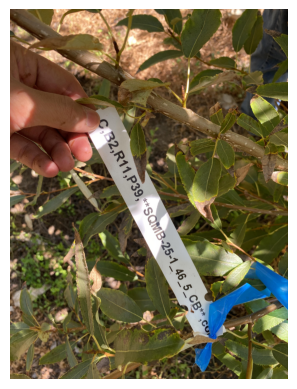

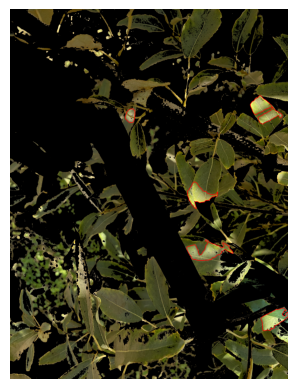

In [43]:
def get_optimized_contours(img: cv2.Image, n: int = 1, debug: bool = False) -> list[cv2.Contour]:
    """ minimize the area of the rectangle and maximize contour area """
    contours = get_contours(img, debug)
    adjusted_contours = []
    for contour in contours:
        _, _, w, h = cv2.boundingRect(contour)
        adjusted_contours.append([contour, cv2.contourArea(contour)**1.5/(w*h)])
    return [x[0] for x in sorted(adjusted_contours, key=lambda x: x[1], reverse=True)[:n]]

def get_leaves(img: cv2.Image, debug: bool = True) -> Any:
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 70, 60), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)
    biggest_leaves = get_optimized_contours(masked, n=5, debug=False)
    masked = cv2.drawContours(masked, biggest_leaves, -1, (0, 0, 255), 5)
    if debug: imshow(masked)

filename = f"dataset/{get_random_filename(SHEET_DATA)}"
# filename = '' # uncomment this line to mess around with a specific filename
print(filename)
img = cv2.imread(filename)
imshow(img)
get_leaves(img, debug=True)

Approach 2: Use Canny Edge detection and image masking

dataset/197711E5-D90E-4787-AE0B-20BACE919328.jpg


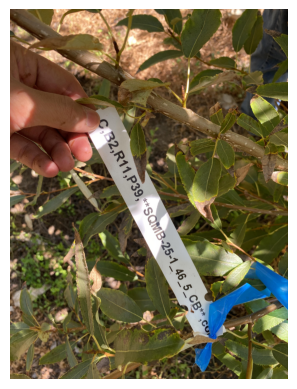

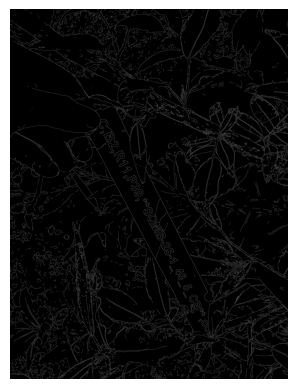

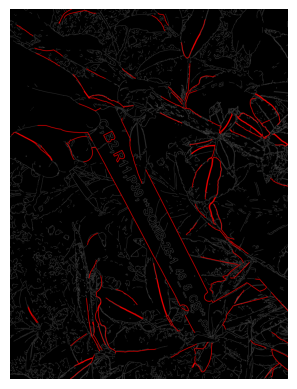

In [61]:
def get_leaves(img: cv2.Image, debug: bool = True) -> Any:
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 70, 60), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)
    biggest_leaves = get_optimized_contours(masked, n=5, debug=False)
    masked = cv2.drawContours(masked, biggest_leaves, -1, (0, 0, 255), 5)
    if debug: imshow(masked)

filename = f"dataset/{get_random_filename(SHEET_DATA)}"
filename = 'dataset/197711E5-D90E-4787-AE0B-20BACE919328.jpg' # uncomment this line to mess around with a specific filename
print(filename)
img = cv2.imread(filename)
imshow(img)
img_blur = cv2.GaussianBlur(img, (13, 13), sigmaX=0, sigmaY=0) 
edges = cv2.Canny(img_blur, threshold1=0, threshold2=50)
imshow(edges)
cv2.imwrite("edges.png", edges)
contours = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
contours = sorted(contours, key=lambda x: float(np.prod(cv2.boundingRect(x)[-2:])), reverse=True)[:100]
drawn_contours = cv2.drawContours(cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), contours, -1, (0, 0, 255), 5)
imshow(drawn_contours)